In [2]:
import sys

sys.path.append("..")
from omegaconf import OmegaConf
from sgm.util import instantiate_from_config

config = OmegaConf.load("../configs/example_training/svd_interpolation.yaml")
print(config)
config["model"]["params"]["ckpt_path"] = "../checkpoints/svd.safetensors"
video_model = instantiate_from_config(config.model)

{'model': {'base_learning_rate': 3e-05, 'target': 'sgm.models.diffusion.DiffusionEngine', 'params': {'input_key': 'latents', 'no_log_keys': ['audio_emb', 'fps_id', 'motion_bucket_id', 'cond_aug'], 'scale_factor': 0.18215, 'disable_first_stage_autocast': True, 'ckpt_path': 'checkpoints/svd.safetensors', 'remove_keys_from_weights': ['model.diffusion_model.input_blocks.0.0.weight'], 'compile_model': False, 'scheduler_config': {'target': 'sgm.lr_scheduler.LambdaLinearScheduler', 'params': {'warm_up_steps': [1000], 'cycle_lengths': [10000000000000], 'f_start': [1e-06], 'f_max': [1.0], 'f_min': [1.0]}}, 'use_lora': False, 'lora_config': {'search_class_str': 'Linear', 'target_replace_module': None, 'r_linear': 16, 'r_conv': 16, 'loras': None}, 'denoiser_config': {'target': 'sgm.modules.diffusionmodules.denoiser.Denoiser', 'params': {'scaling_config': {'target': 'sgm.modules.diffusionmodules.denoiser_scaling.VScalingWithEDMcNoise'}}}, 'network_wrapper': {'target': 'sgm.modules.diffusionmodules

  warnings.warn("Initializing zero-element tensors is a no-op")

INFO:sgm.modules.diffusionmodules.openaimodel:Building a Downsample layer with 2 dims.
INFO:sgm.modules.diffusionmodules.openaimodel:  --> settings are: 
 in-chn: 320, out-chn: 320, kernel-size: 3, stride: 2, padding: 1


VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing


INFO:sgm.modules.diffusionmodules.openaimodel:Building a Downsample layer with 2 dims.
INFO:sgm.modules.diffusionmodules.openaimodel:  --> settings are: 
 in-chn: 640, out-chn: 640, kernel-size: 3, stride: 2, padding: 1


VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing


INFO:sgm.modules.diffusionmodules.openaimodel:Building a Downsample layer with 2 dims.
INFO:sgm.modules.diffusionmodules.openaimodel:  --> settings are: 
 in-chn: 1280, out-chn: 1280, kernel-size: 3, stride: 2, padding: 1


VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing
VideoTransformerBlock is using checkpointing


INFO:root:Loaded ViT-H-14 model config.
INFO:root:Loading pretrained ViT-H-14 weights (laion2b_s32b_b79k).
INFO:sgm.modules.diffusionmodules.model:making attention of type 'vanilla-xformers' with 512 in_channels
INFO:sgm.modules.diffusionmodules.model:building MemoryEfficientAttnBlock with 512 in_channels...


Initialized embedder #0: FrozenOpenCLIPImagePredictionEmbedder with 683800065 params. Trainable: False
Initialized embedder #1: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False


INFO:sgm.modules.diffusionmodules.model:Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
INFO:sgm.modules.diffusionmodules.model:making attention of type 'vanilla-xformers' with 512 in_channels
INFO:sgm.modules.diffusionmodules.model:building MemoryEfficientAttnBlock with 512 in_channels...


Initialized embedder #3: VideoPredictionEmbedderWithEncoder with 83653863 params. Trainable: False
Initialized embedder #4: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #5: WhisperAudioEmbedder with 1311744 params. Trainable: True


INFO:sgm.modules.diffusionmodules.model:making attention of type 'vanilla' with 512 in_channels
INFO:sgm.modules.diffusionmodules.model:Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
INFO:sgm.modules.diffusionmodules.openaimodel:Skipping timestep embedding in ResBlock
INFO:sgm.modules.diffusionmodules.model:making attention of type 'vanilla' with 512 in_channels
INFO:sgm.modules.diffusionmodules.openaimodel:Skipping timestep embedding in ResBlock
INFO:sgm.modules.diffusionmodules.openaimodel:Skipping timestep embedding in ResBlock
INFO:sgm.modules.diffusionmodules.openaimodel:Skipping timestep embedding in ResBlock
INFO:sgm.modules.diffusionmodules.openaimodel:Skipping timestep embedding in ResBlock
INFO:sgm.modules.diffusionmodules.openaimodel:Skipping timestep embedding in ResBlock
INFO:sgm.modules.diffusionmodules.openaimodel:Skipping timestep embedding in ResBlock
INFO:sgm.modules.diffusionmodules.openaimodel:Skipping timestep embedding in ResBlock
INFO:sgm.modules.diffu

Restoring from ../checkpoints/svd.safetensors
Loaded state dict from ../checkpoints/svd.safetensors with 2446 keys
Restored from ../checkpoints/svd.safetensors with 436 missing and 0 unexpected keys
Missing Keys: ['model.learned_mask', 'model.diffusion_model.input_blocks.0.0.weight', 'model.diffusion_model.input_blocks.1.1.audio_stack.0.norm_in.weight', 'model.diffusion_model.input_blocks.1.1.audio_stack.0.norm_in.bias', 'model.diffusion_model.input_blocks.1.1.audio_stack.0.ff_in.net.0.proj.weight', 'model.diffusion_model.input_blocks.1.1.audio_stack.0.ff_in.net.0.proj.bias', 'model.diffusion_model.input_blocks.1.1.audio_stack.0.ff_in.net.2.weight', 'model.diffusion_model.input_blocks.1.1.audio_stack.0.ff_in.net.2.bias', 'model.diffusion_model.input_blocks.1.1.audio_stack.0.attn1.to_q.weight', 'model.diffusion_model.input_blocks.1.1.audio_stack.0.attn1.to_k.weight', 'model.diffusion_model.input_blocks.1.1.audio_stack.0.attn1.to_v.weight', 'model.diffusion_model.input_blocks.1.1.audio_s

In [ ]:
model.model.learned_mask.sum((1, 2))

In [ ]:
from torchvision.io import read_video
import torch

video_path = "/data2/Datasets/HDTF/cropped_videos_original/WRA_BobbySchilling_001.mp4"
resolution = 512
device = torch.device("cuda")

video, audio, info = read_video(video_path, pts_unit="sec", output_format="TCHW")

from torchvision.transforms import Resize

resize = Resize((resolution, resolution))
video = resize(video)
print(video.shape)

In [ ]:
audio_path = "/data2/Datasets/HDTF/audio/WRA_BobbySchilling_001_whisper_emb.pt"
audio = torch.load(audio_path)
print(audio.shape)

In [ ]:
video.min(), video.max()

In [ ]:
model.first_stage_model.encoder

In [ ]:
model = model.to(device)
encoded = model.conditioner.embedders[3]((video[:2].to(device).float() / 255.0) * 2 - 1)

In [3]:
from safetensors.torch import load_file

encoded = load_file(
    "/fsx/behavioural_computing_data/face_generation_data/CelebV_HQ/video_crop_latents/100/g4FOpeshqA8_1_0_103_video_512_latent.safetensors"
)["latents"]
encoded.shape

torch.Size([103, 4, 64, 64])

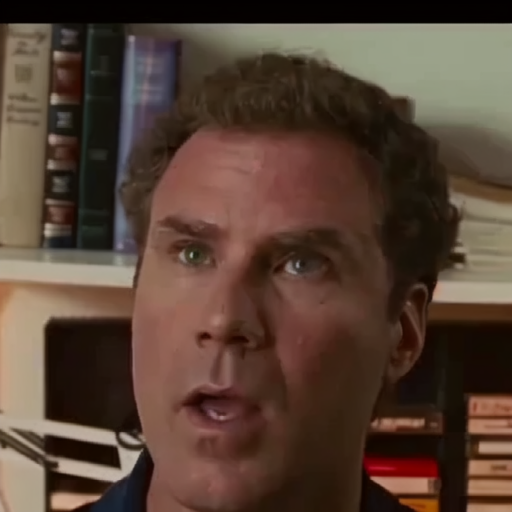

In [6]:
from PIL import Image
import numpy as np

# video_model.to(device)
# decoded = video_model.decode_first_stage(encoded[:, 4:])
decoded = video_model.decode_first_stage(encoded[:2])
img = Image.fromarray(np.uint8((decoded[0].clip(-1, 1).cpu().numpy().transpose(1, 2, 0) + 1) * 255 / 2))
display(img)

In [ ]:
from safetensors.torch import load_file

latent_path = "/vol/bitbucket/abigata/00190_video_512_latent.safetensors"

latent = load_file(latent_path)
latent["latents"].shape

In [ ]:
decoded = video_model.decode_first_stage(latent["latents"][:1].to("cpu"))

In [ ]:
from PIL import Image
import numpy as np

img = Image.fromarray(np.uint8((decoded[0].clip(-1, 1).cpu().numpy().transpose(1, 2, 0) + 1) * 255 / 2))
display(img)

In [ ]:
import sys

sys.path.append("..")
from omegaconf import OmegaConf
from sgm.util import instantiate_from_config

config = OmegaConf.load(
    "/vol/paramonos2/projects/antoni/code/Personal/generative-models/configs/inference/sd_2_1.yaml"
)
print(config)
config["model"]["params"]["ckpt_path"] = (
    "/vol/paramonos2/projects/antoni/code/Personal/generative-models/checkpoints/v2-1_512-ema-pruned.safetensors"
)
model = instantiate_from_config(config.model)

In [ ]:
from torchvision.io import read_video
import torch

video_path = "/data2/Datasets/HDTF/cropped_videos_original/WRA_BobbySchilling_001.mp4"
resolution = 512
device = torch.device("cuda:4")

video, audio, info = read_video(video_path, pts_unit="sec", output_format="TCHW")

from torchvision.transforms import Resize

resize = Resize((resolution, resolution))
video = resize(video)
print(video.shape)

In [ ]:
model.to(device)
encoded = model.encode_first_stage((video[:2].to(device).float() / 255.0) * 2 - 1)

In [ ]:
# decoded = model.decode_first_stage(encoded)
decoded = model.decode_first_stage(latent["latents"][:1].to(device))

In [ ]:
from PIL import Image
import numpy as np

img = Image.fromarray(np.uint8((decoded[0].clip(-1, 1).cpu().numpy().transpose(1, 2, 0) + 1) * 255 / 2))
display(img)

In [1]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

# load model and tokenizer
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h", cache_dir="/vol/bitbucket/abigata/.cache")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h", cache_dir="/vol/bitbucket/abigata/.cache")

/vol/paramonos2/projects/antoni/miniconda3/envs/svd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were 

In [2]:
import torchaudio

audio_path = "/data2/Datasets/HDTF/audio/WRA_JeffFlake_001.wav"
audio, sr = torchaudio.load(audio_path)

In [25]:
audio.shape

torch.Size([1, 4800029])

In [ ]:
from einops import rearrange

audio_reshaped = rearrange(audio.mean(0)[:640000], "(f s) -> f s", s=320)
audio_reshaped.shape

In [ ]:
processed = processor(audio=audio_reshaped, sampling_rate=sr, return_tensors="pt", padding="longest").input_values

In [ ]:
processed.shape

In [3]:
import torch

normed_slice = (audio - audio.mean()) / torch.sqrt(audio.var() + 1e-7)

In [5]:
normed_slice.shape

torch.Size([1, 4800029])

In [16]:
with torch.no_grad():
    outs = model(normed_slice[:, : 16000 * 3], output_hidden_states=True)
    # hidden_states = model.wav2vec2(normed_slice)

In [8]:
outs.logits.shape

torch.Size([1, 49, 32])

In [18]:
from einops import rearrange

rearanged = rearrange(hidden_states[0], "() (f d) c -> f d c", d=2)

In [20]:
rearanged[1]

tensor([[ 0.0689, -0.0591,  0.0395,  ...,  0.0656,  0.0215, -0.1854],
        [ 0.0147, -0.0275, -0.0192,  ..., -0.0795,  0.0946,  0.0547]])

In [21]:
outs.hidden_states[-1][:, 2:4]

tensor([[[ 0.0689, -0.0591,  0.0395,  ...,  0.0656,  0.0215, -0.1854],
         [ 0.0147, -0.0275, -0.0192,  ..., -0.0795,  0.0946,  0.0547]]])

In [28]:
from torchvision.io import read_video

video_path = "/data2/Datasets/HDTF/cropped_videos_original/WRA_JeffFlake_001.mp4"
resolution = 512
device = torch.device("cuda:4")

video, audio, info = read_video(video_path, pts_unit="sec", output_format="TCHW")
video.shape

torch.Size([7500, 3, 788, 788])

In [30]:
outs.logits.shape, 7500 * 2

(torch.Size([1, 14999, 32]), 15000)

In [17]:
predicted_ids = torch.argmax(outs.logits, dim=-1).squeeze()

# transcribe
transcription = processor.decode(predicted_ids)
transcription

"NTRIES I'VE NEVER HAD FOR A SINGLE DAY IN"

: 

In [ ]:
"NTRIES HAVE NEVER HAD FOR A SINGLE DAY IN THEIR LIVES BUT THE STORY OF THE PAST THREE AND A HALF YEARS IS A STORY OF THE POWER THAT WE VEST IN THE PRESIDENCY"